# =============================================================
# MILESTONE 1: Data Collection, Exploration, and Preprocessing
# =============================================================

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

In [2]:
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ========================
# 1. DATA COLLECTION
# ========================

In [3]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/processed/merged_churn_data.csv"
df = pd.read_csv(url)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset loaded: 3333 rows, 20 columns


In [4]:
df_before = df.copy()

# ========================
# 2. INITIAL DATA EXPLORATION
# ========================

In [5]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [7]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [8]:
print(df.duplicated().sum())

0


In [9]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [10]:
df['Churn'].value_counts()

Churn
False    2850
True      483
Name: count, dtype: int64

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\3219302036.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set2')


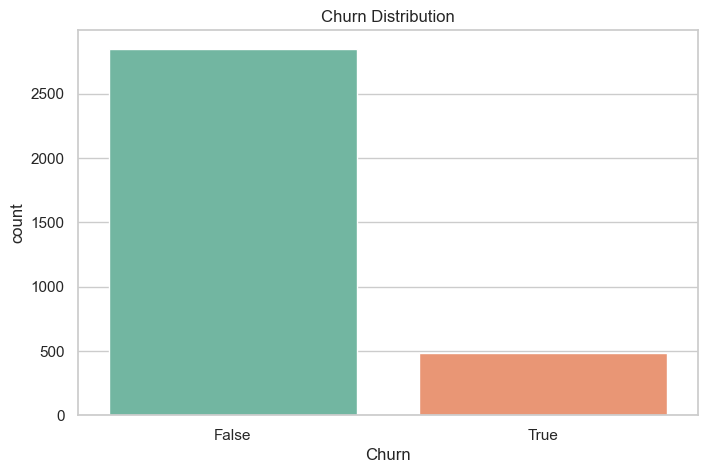

In [11]:
# Churn Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Churn Distribution')
plt.savefig(f'../visualizations/enhanced/churn_distribution.png')
plt.show()

# ========================
# 3. DATA CLEANING & PREPROCESSING
# ========================

# -------------------------------------
# 3.1 Remove Duplicates
# -------------------------------------

In [12]:
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed {df.duplicated().sum()} duplicates")
else:
    print("No duplicates found")

No duplicates found


# -------------------------------------
# 3.2 Handle Missing Values
# -------------------------------------

In [13]:
if df.isnull().sum().sum() > 0:
    print("Missing values found")
else:
    print("No missing values found")

No missing values found


In [14]:
# Handle missing values by imputation (example: fill with median)
for column in df.select_dtypes(include=[np.number]).columns:
    df[column].fillna(df[column].median(), inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\843874314.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)


# -------------------------------------
# 3.3 Outlier Detection & Clipping
# -------------------------------------

In [15]:
numeric_cols = [
    'Total day minutes', 'Total day charge', 
    'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 
    'Total intl minutes', 'Total intl charge',
    'Account length'
]

In [16]:
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before clipping
    outlier_mask_col = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_counts[col] = outlier_mask_col.sum()
    
    # Clip values in the original dataframe
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers detected before clipping:")
for col, count in outlier_counts.items():
    print(f"  {col}: {count} outliers")
print("Outliers clipped to IQR bounds")

Outliers detected before clipping:
  Total day minutes: 25 outliers
  Total day charge: 25 outliers
  Total eve minutes: 24 outliers
  Total eve charge: 24 outliers
  Total night minutes: 30 outliers
  Total night charge: 30 outliers
  Total intl minutes: 46 outliers
  Total intl charge: 49 outliers
  Account length: 18 outliers
Outliers clipped to IQR bounds


In [17]:
Q1_all = df_before[numeric_cols].quantile(0.25)  
Q3_all = df_before[numeric_cols].quantile(0.75)
IQR_all = Q3_all - Q1_all

mask_no_outliers = ~((df_before[numeric_cols] < (Q1_all - 1.5 * IQR_all)) | 
                     (df_before[numeric_cols] > (Q3_all + 1.5 * IQR_all))).any(axis=1)

df_no_outliers = df_before[mask_no_outliers]

In [18]:
df.to_csv('../data/interim/imputed_data.csv', index=False)
df_no_outliers.to_csv('../data/interim/outlier_removed_data.csv', index=False)
print(f"Interim files saved: imputed_data.csv and outlier_removed_data.csv")

Interim files saved: imputed_data.csv and outlier_removed_data.csv


# -------------------------------------
# 3.4 Feature Engineering
# -------------------------------------

In [19]:
df['Total_Charge'] = (
    df['Total day charge'] + df['Total eve charge'] + 
    df['Total night charge'] + df['Total intl charge']
)
df['Total_Minutes'] = (
    df['Total day minutes'] + df['Total eve minutes'] + 
    df['Total night minutes'] + df['Total intl minutes']
)

In [20]:
df['Avg_Minute_Cost'] = df['Total_Charge'] / df['Total_Minutes'].replace(0, np.nan)
df['Avg_Minute_Cost'] = df['Avg_Minute_Cost'].fillna(df['Avg_Minute_Cost'].median())

In [21]:
df['Total_Calls'] = (
    df['Total day calls'] + df['Total eve calls'] + 
    df['Total night calls'] + df['Total intl calls']
)

In [22]:
df['High_Customer_Service'] = (df['Customer service calls'] > 3).astype(int)  # Binary feature
df['Account_Length_Binned'] = pd.qcut(df['Account length'], q=3, labels=['Short', 'Medium', 'Long'])

In [23]:
print("New features created: 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned'")

New features created: 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned'


In [24]:
print(df[['Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service', 'Account_Length_Binned']].describe())

       Total_Charge  Total_Minutes  Avg_Minute_Cost  Total_Calls  \
count   3333.000000    3333.000000      3333.000000  3333.000000   
mean      59.462009     591.908416         0.100368   305.137114   
std       10.433074      89.268378         0.008347    34.448164   
min       27.020000     284.300000         0.067938   191.000000   
25%       52.380000     531.800000         0.094893   282.000000   
50%       59.470000     593.700000         0.100390   305.000000   
75%       66.480000     652.400000         0.106056   328.000000   
max       92.520000     882.200000         0.129791   416.000000   

       High_Customer_Service  
count            3333.000000  
mean                0.080108  
std                 0.271501  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000  


# -------------------------------------
# 3.5 Encode Target & Categoricals
# -------------------------------------

In [25]:
# Convert Churn (boolean) to 0/1
df['Churn'] = df['Churn'].astype(int)
print("Churn converted to 0/1")

Churn converted to 0/1


In [26]:
# Convert Area code to string for categorical encoding
df['Area code'] = df['Area code'].astype(str)

In [27]:
# One-hot encode categorical columns
categorical_cols = ['State', 'Area code', 'International plan', 'Voice mail plan', 'Account_Length_Binned']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"One-hot encoded {len(categorical_cols)} categorical columns")
print(f"Final dataset shape: {df_encoded.shape}")

One-hot encoded 5 categorical columns
Final dataset shape: (3333, 77)


In [28]:
# Save cleaned dataset
df_encoded.to_csv('../data/interim/initial_cleaned_data.csv', index=False)
print(f"Initial cleaned dataset saved with {df_no_outliers.shape[0]} rows")

Initial cleaned dataset saved with 3189 rows


# ========================
# 4. EXPLORATORY DATA ANALYSIS (VISUALIZATIONS)
# ========================

In [29]:
numeric_cols = [
    'Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl charge',
    'Account length', 'Number vmail messages', 'Total day calls', 'Total eve calls',
    'Total night calls', 'Total intl calls', 'Customer service calls',
    'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls'
]

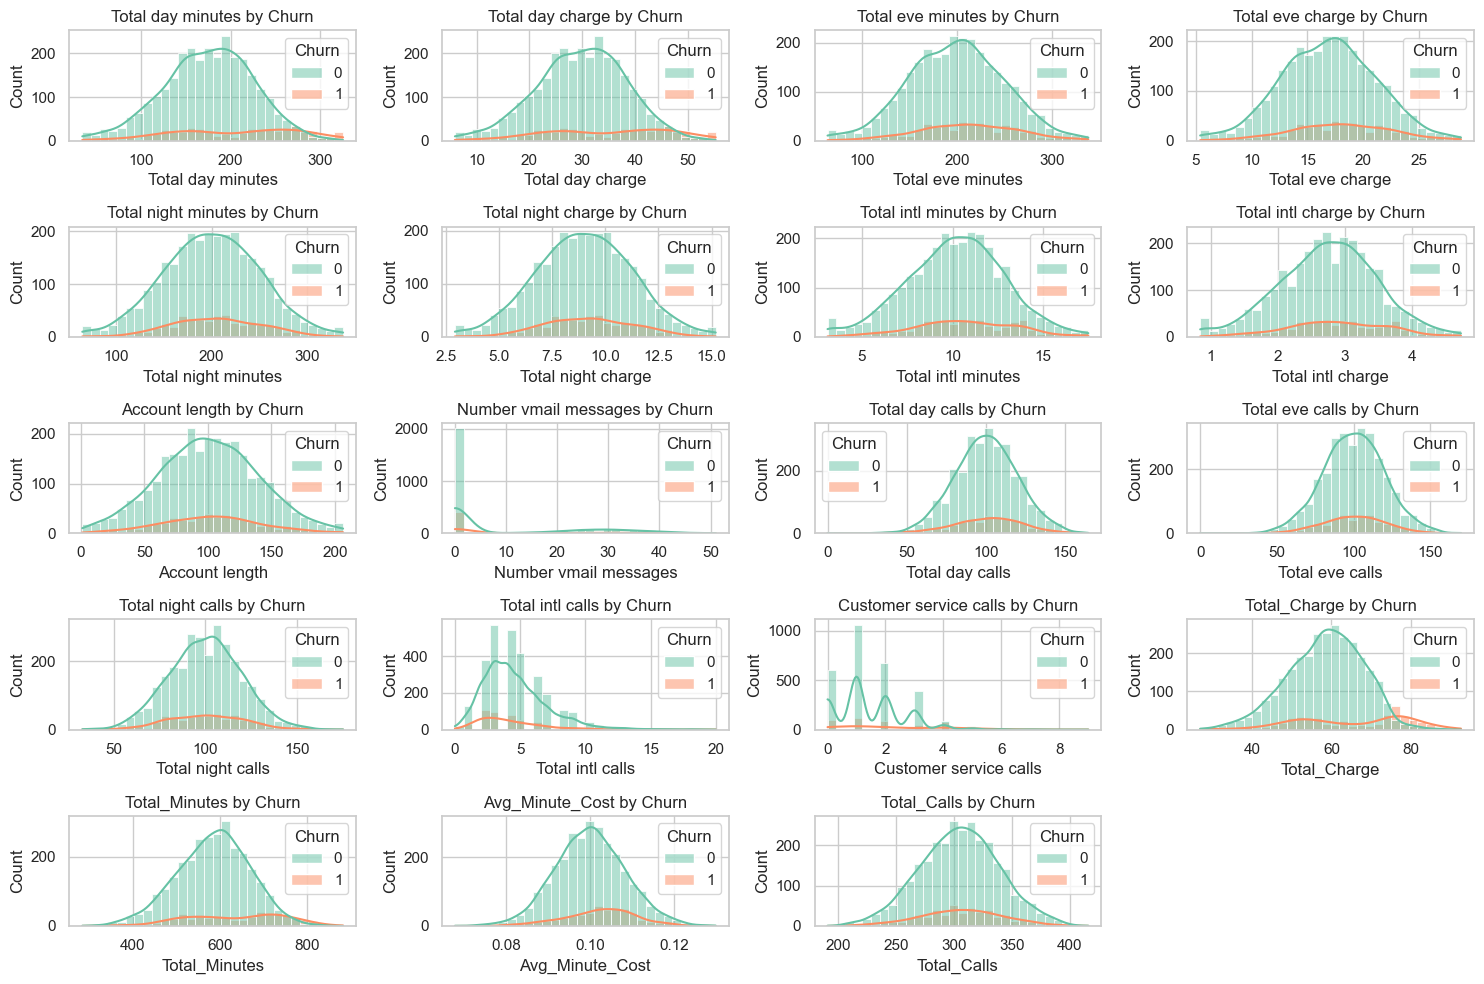

In [30]:
# 1. Histograms for Numerical Columns by Churn
plt.figure(figsize=(15, 10))
n_cols = 4 
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30, palette='Set2', alpha=0.5)
    plt.title(f'{col} by Churn')
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/numerical_columns_by_churn.png')
plt.show()

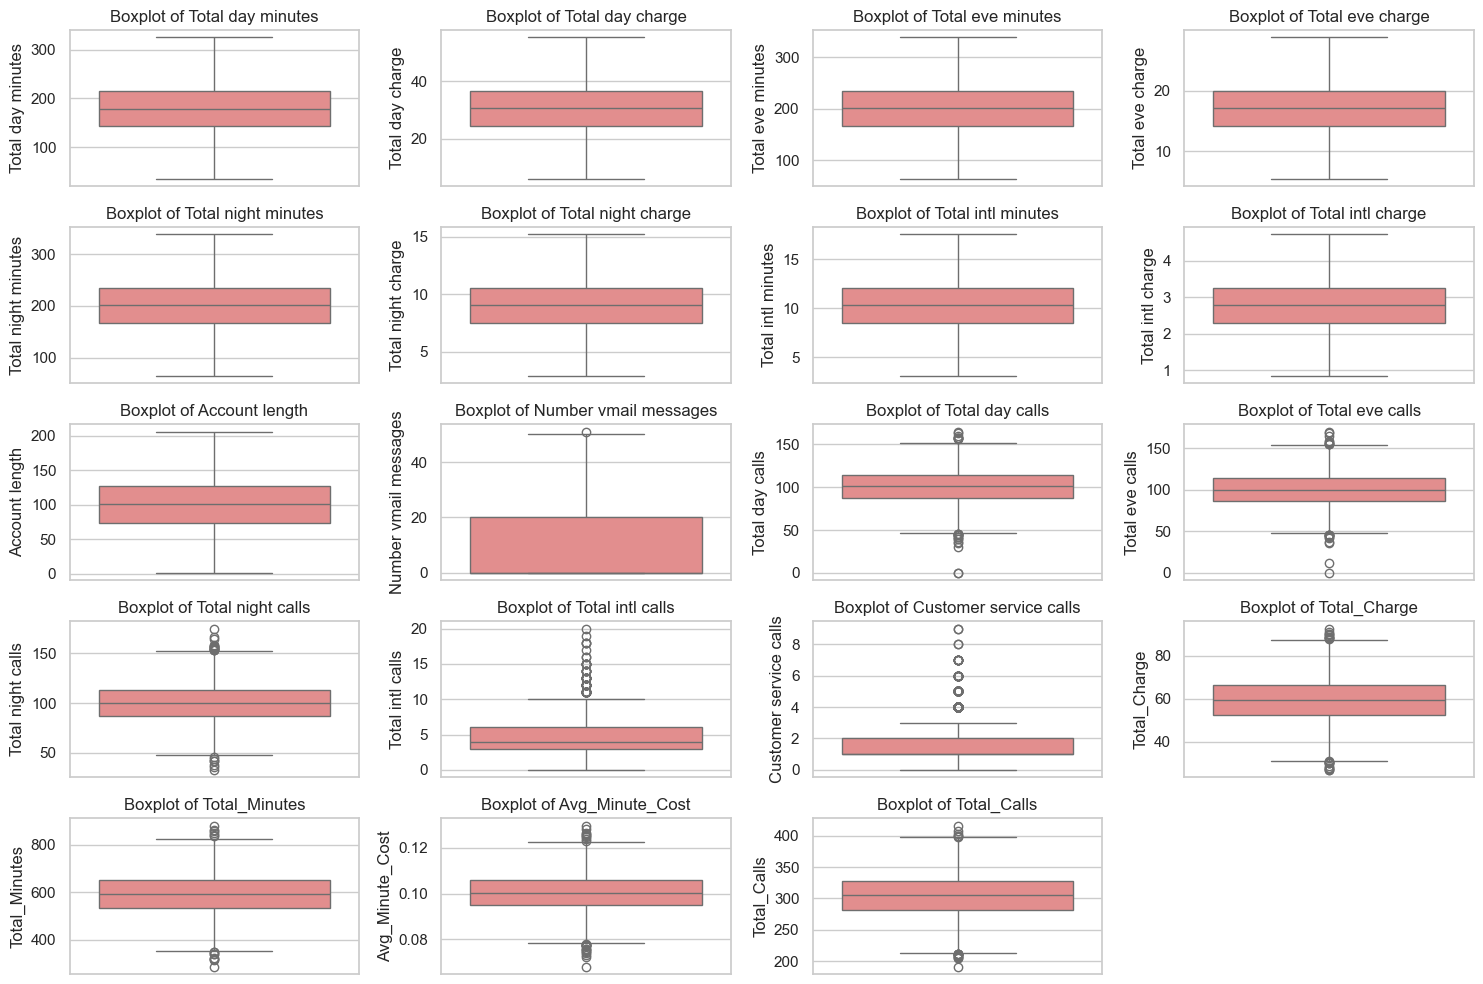

In [31]:
# 2. Boxplots for Numerical Columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/boxplots_for_numerical_columns.png')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\2509324805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\2509324805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\2509324805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\2509324805.py:5: FutureWarnin

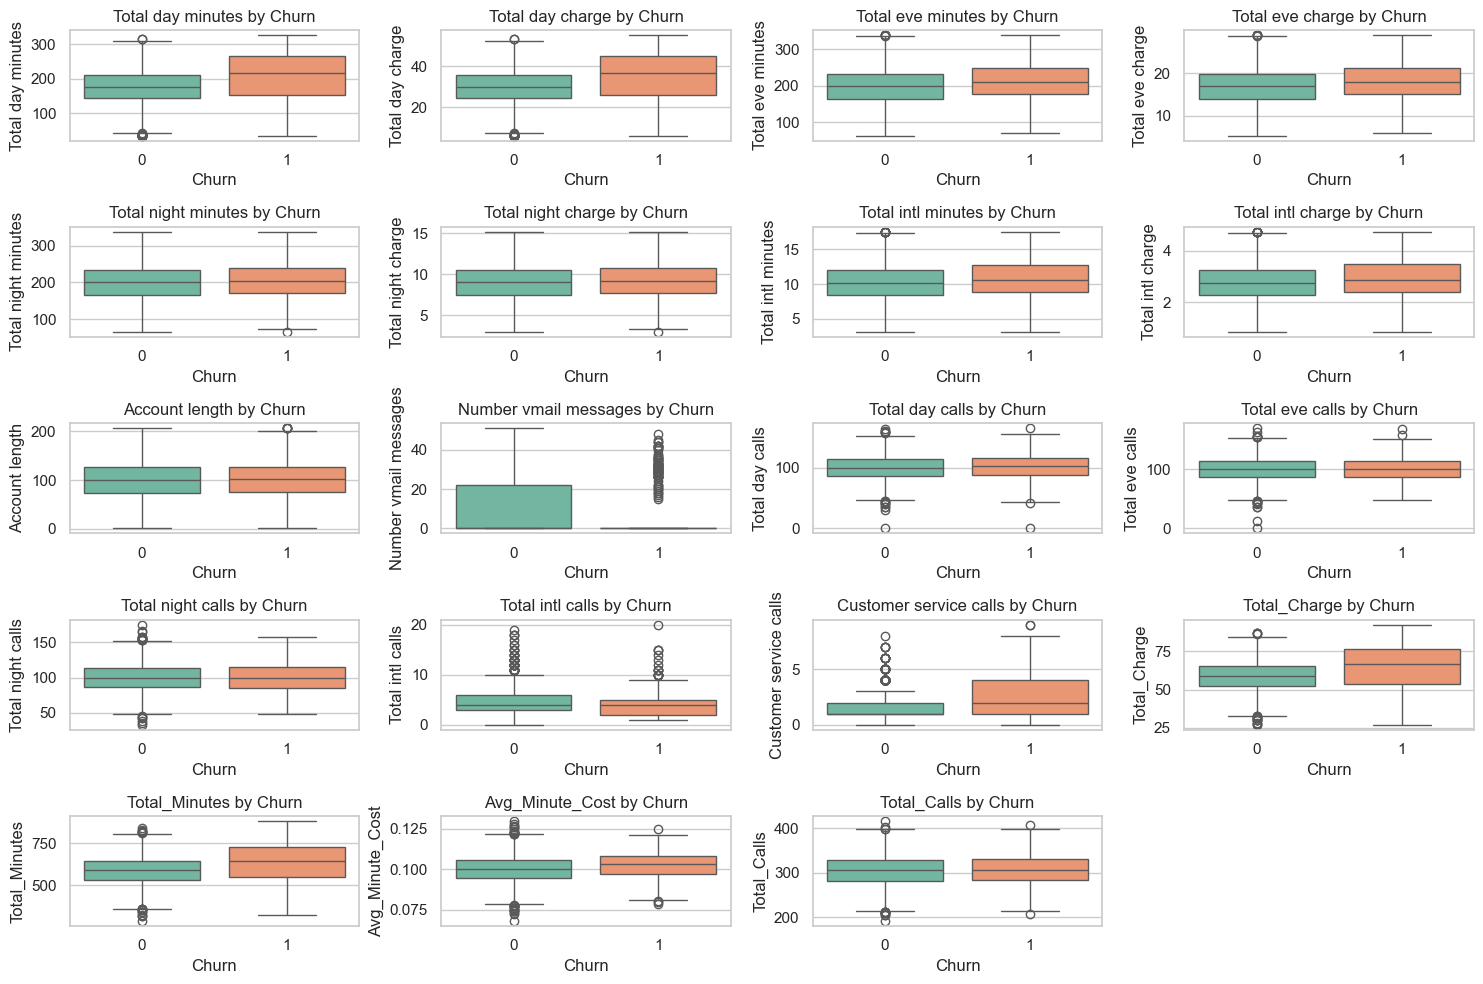

In [32]:
# 3. Boxplots by Churn
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x='Churn', y=col, data=df, palette='Set2')
    plt.title(f'{col} by Churn')
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/boxplots_by_churn.png')
plt.show()

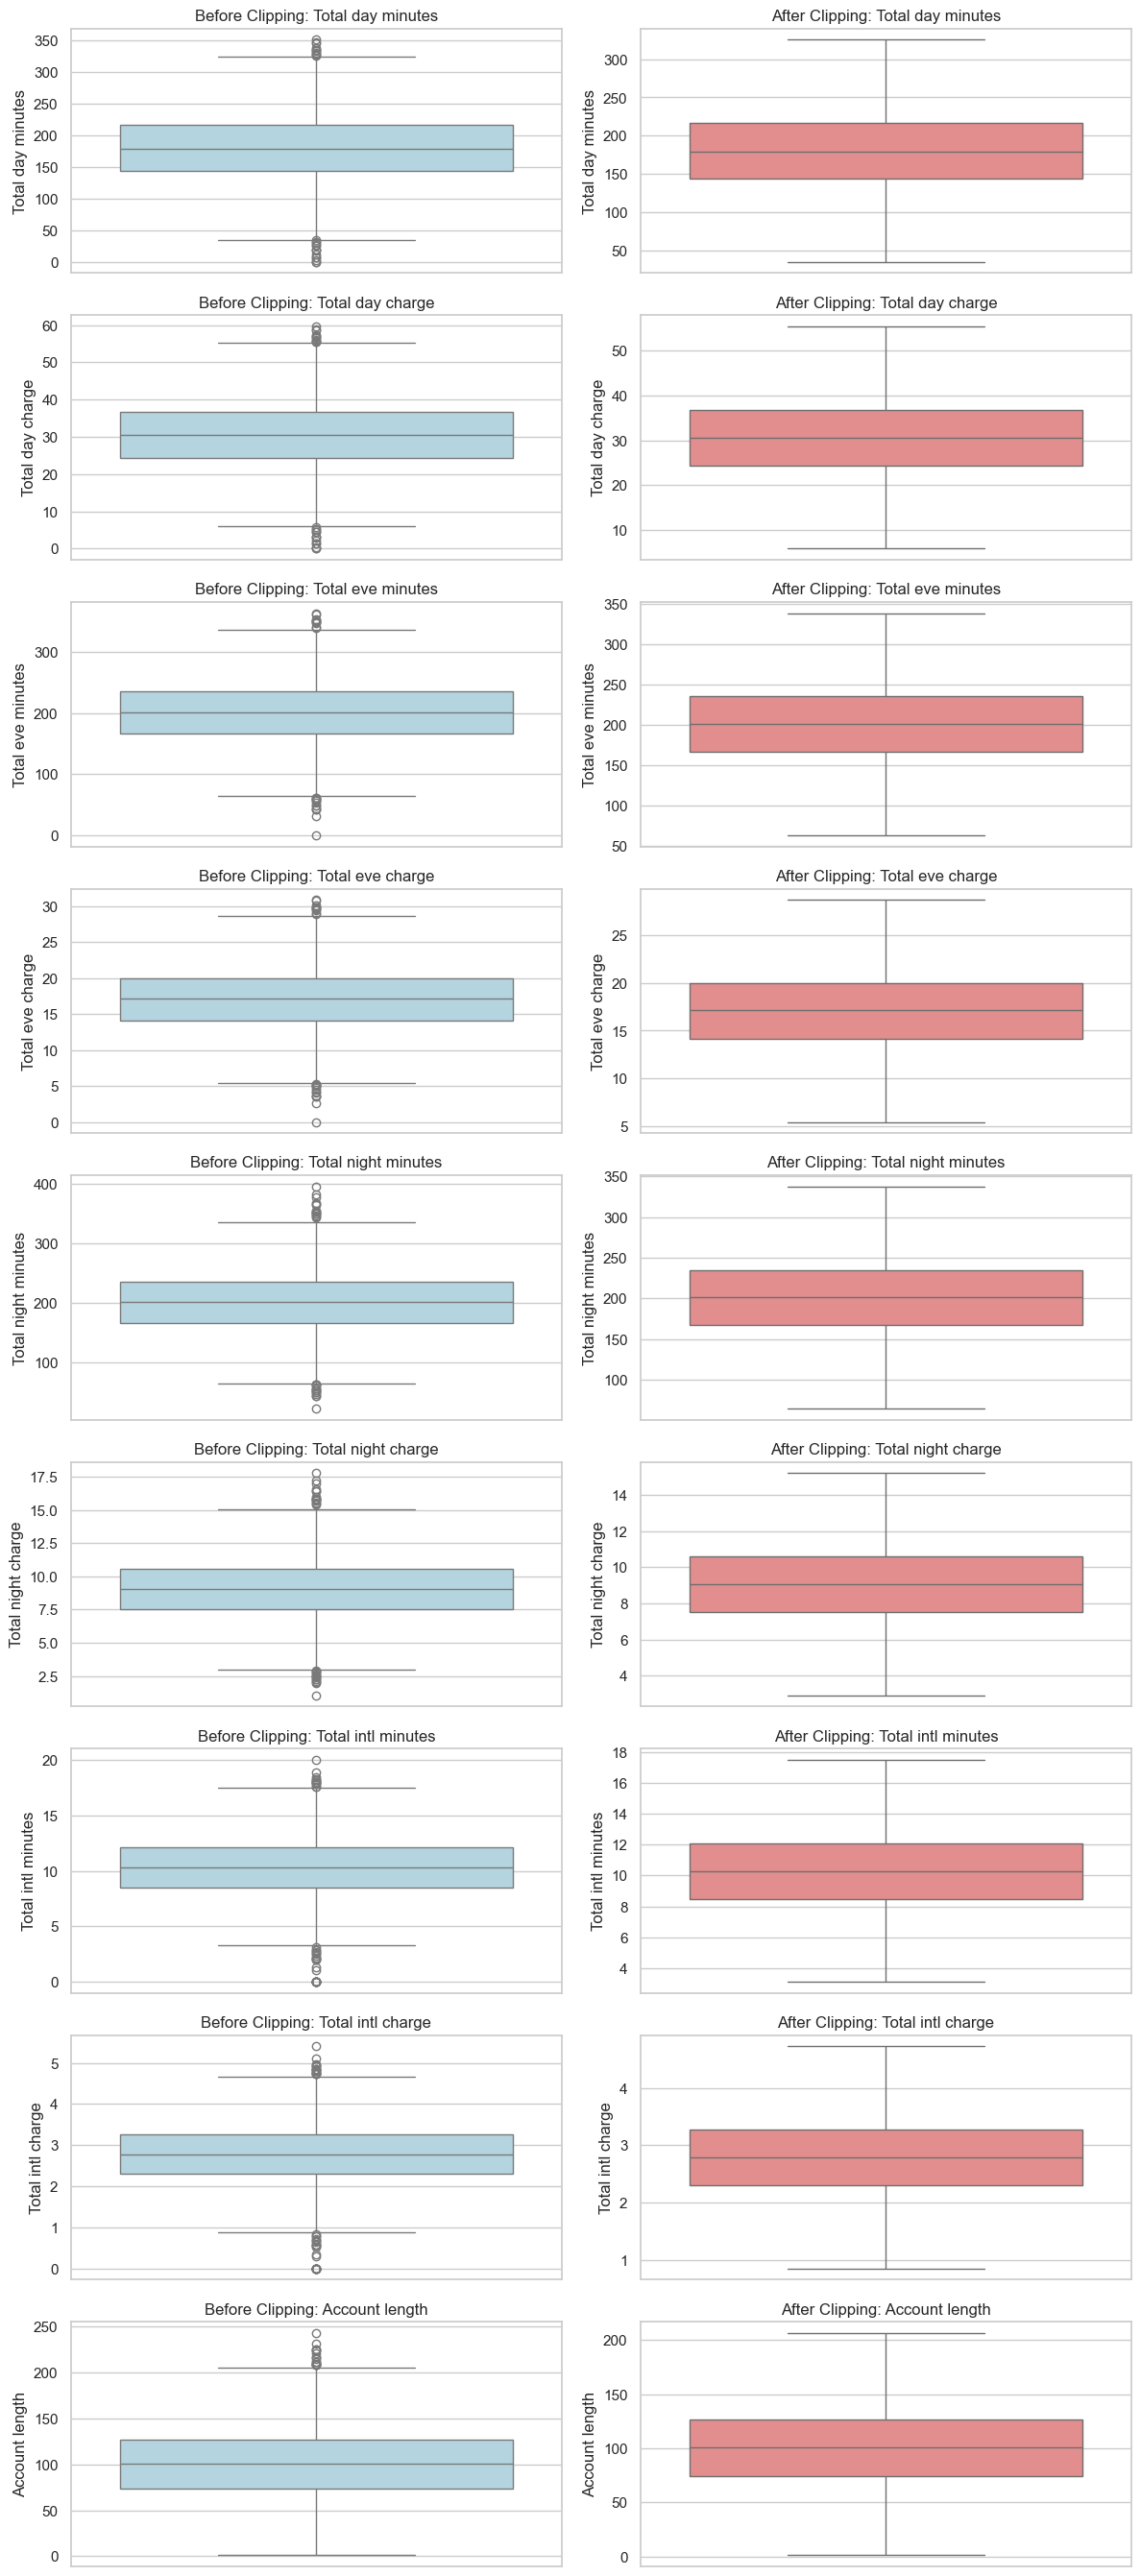

In [33]:
# 4. Side-by-Side Boxplots: Before vs. After Clipping
clipped_cols = [
    'Total day minutes', 'Total day charge', 'Total eve minutes', 'Total eve charge',
    'Total night minutes', 'Total night charge', 'Total intl minutes', 'Total intl charge',
    'Account length'
]

plt.figure(figsize=(12, len(clipped_cols) * 3))
for i, col in enumerate(clipped_cols, 1):
    plt.subplot(len(clipped_cols), 2, 2*i-1)
    sns.boxplot(y=df_before[col], color='lightblue')
    plt.title(f'Before Clipping: {col}')
    plt.subplot(len(clipped_cols), 2, 2*i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'After Clipping: {col}')
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/boxplots_before_after_clipping.png')
plt.show()

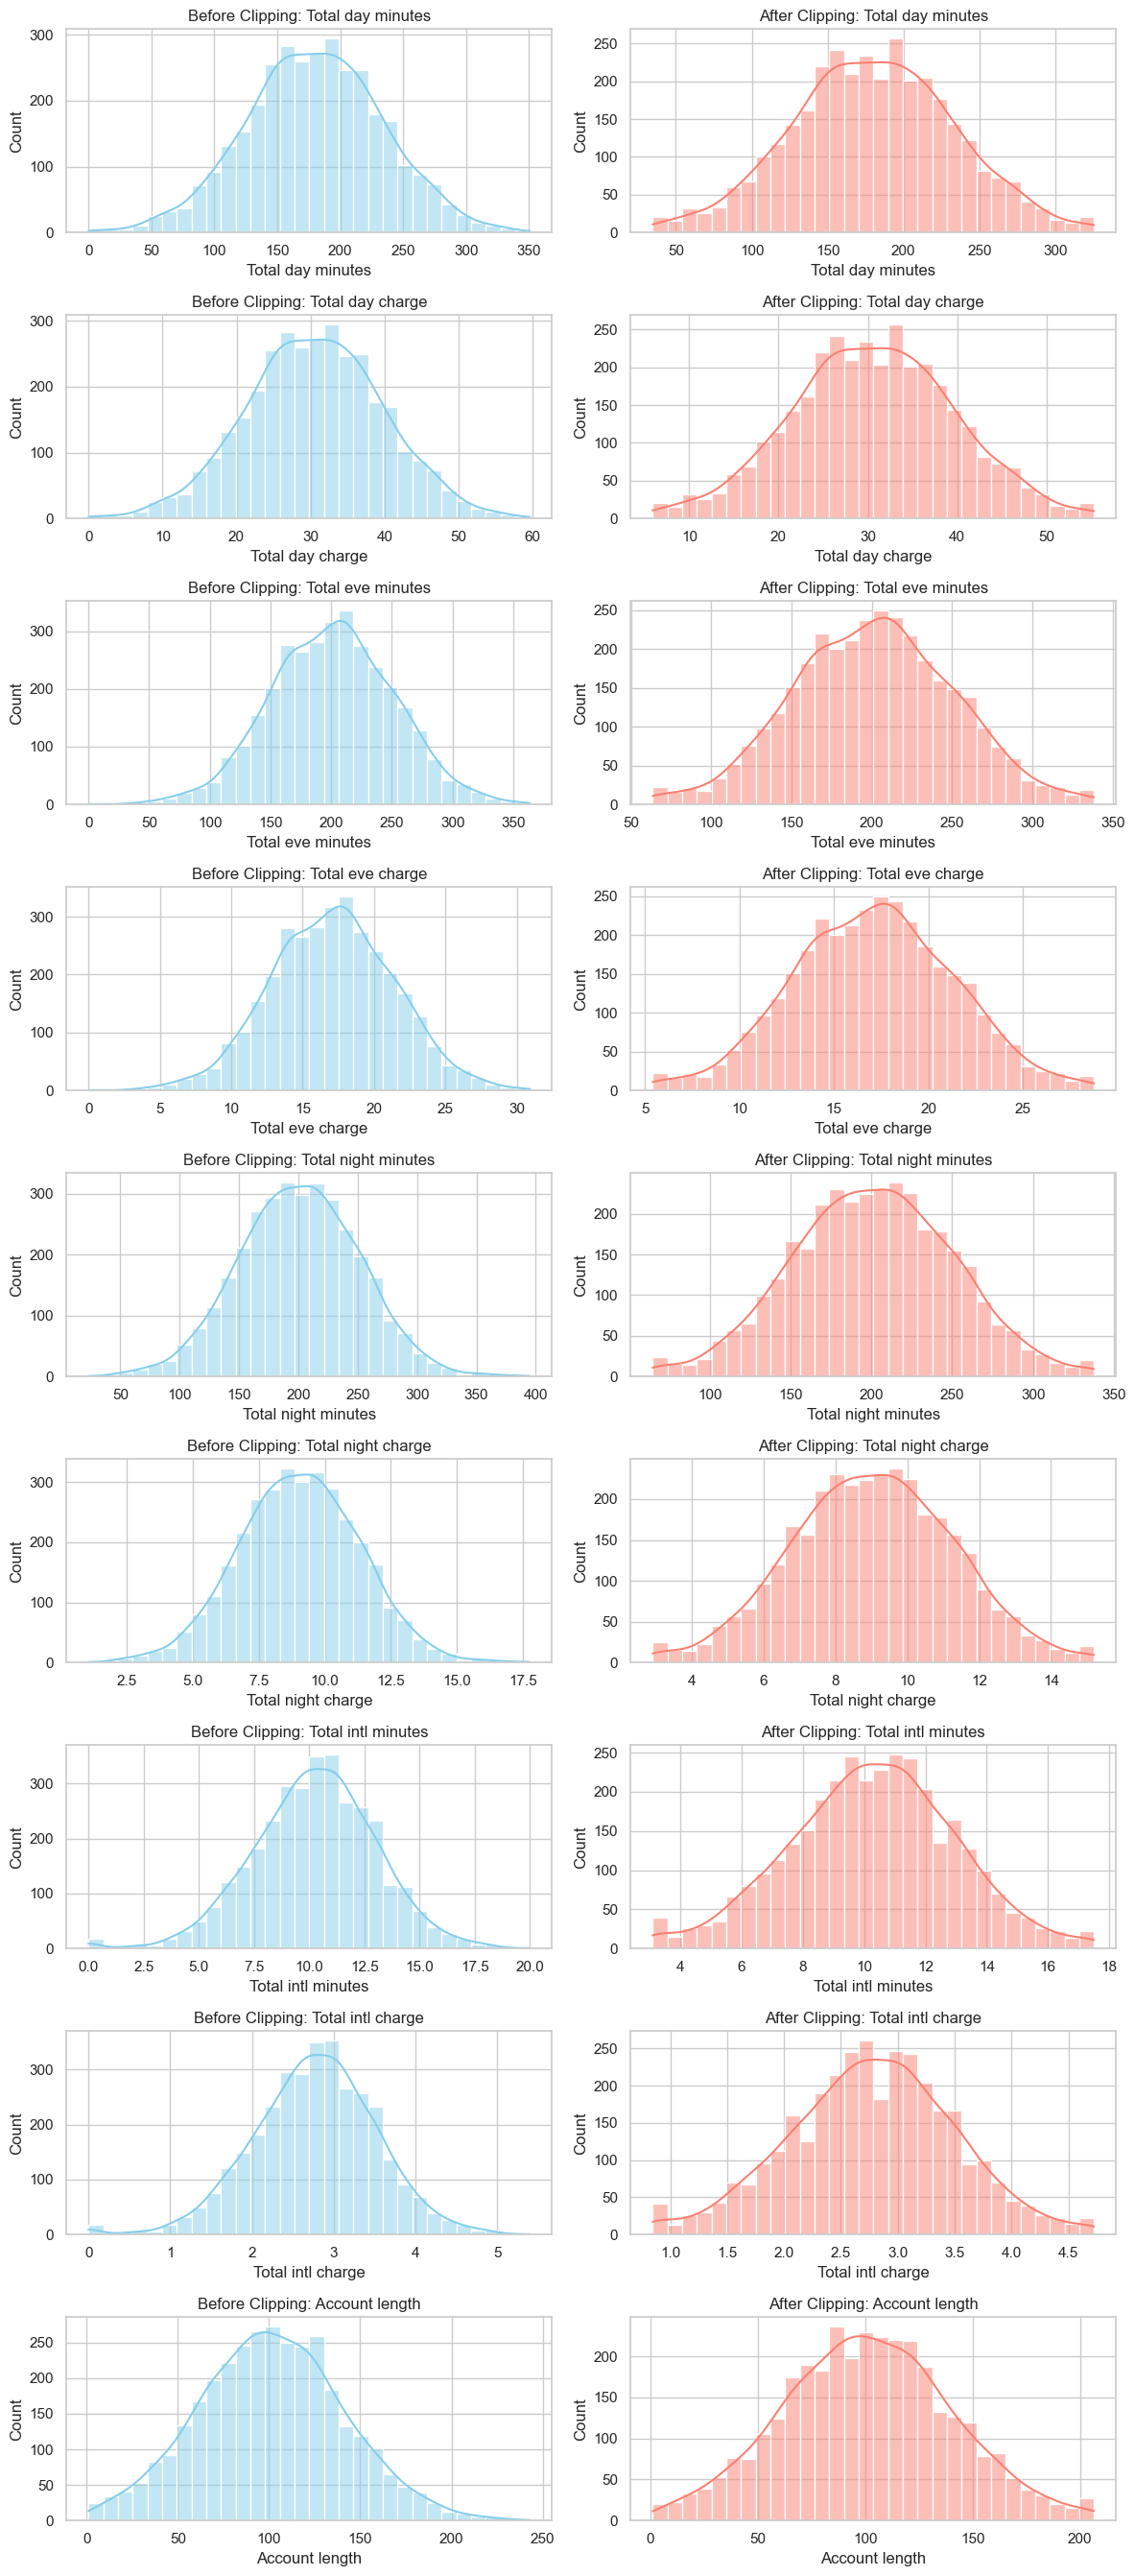

In [34]:
# 5. Side-by-Side Histograms: Before vs. After Clipping
plt.figure(figsize=(12, len(clipped_cols) * 3))
for i, col in enumerate(clipped_cols, 1):
    plt.subplot(len(clipped_cols), 2, 2*i-1)
    sns.histplot(df_before[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Before Clipping: {col}')
    plt.subplot(len(clipped_cols), 2, 2*i)
    sns.histplot(df[col], kde=True, bins=30, color='salmon')
    plt.title(f'After Clipping: {col}')
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/histograms_before_after_clipping.png')
plt.show()

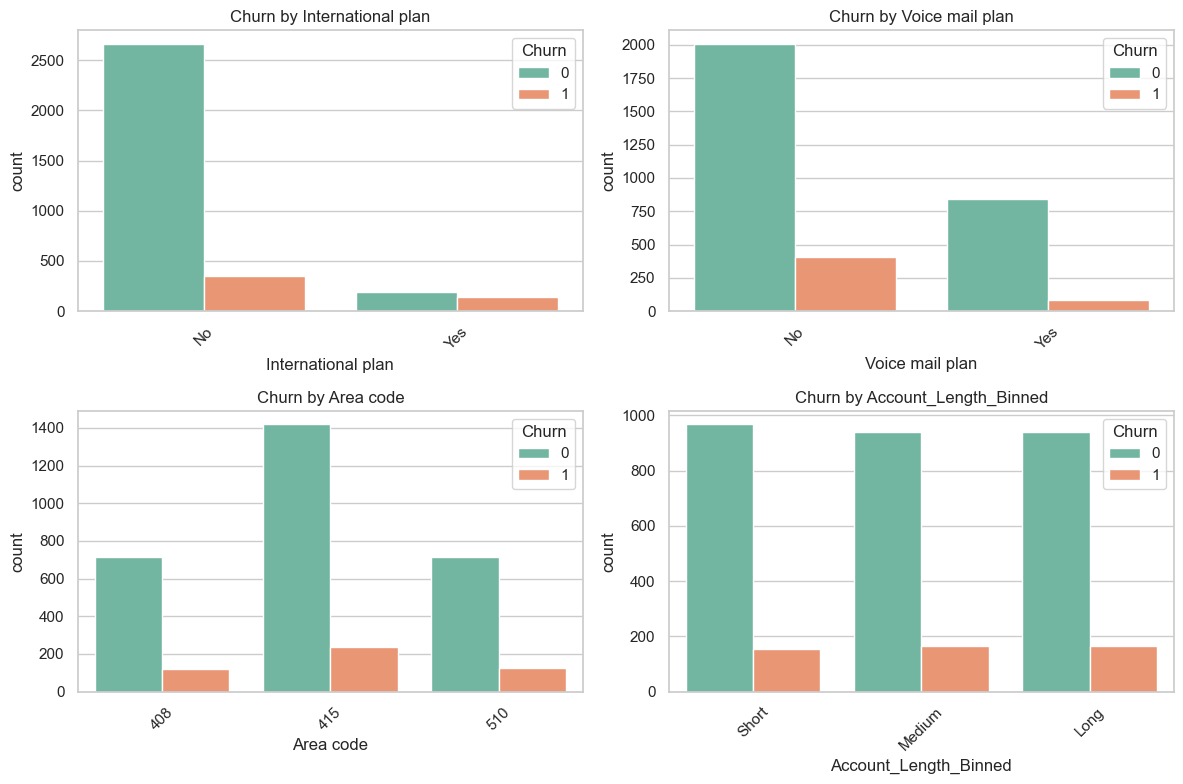

In [35]:
# 6. Categorical Variables vs. Churn
categorical_cols = ['International plan', 'Voice mail plan', 'Area code', 'Account_Length_Binned']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='Churn', data=df, palette='Set2')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/categorical_columns_by_churn.png')
plt.show()

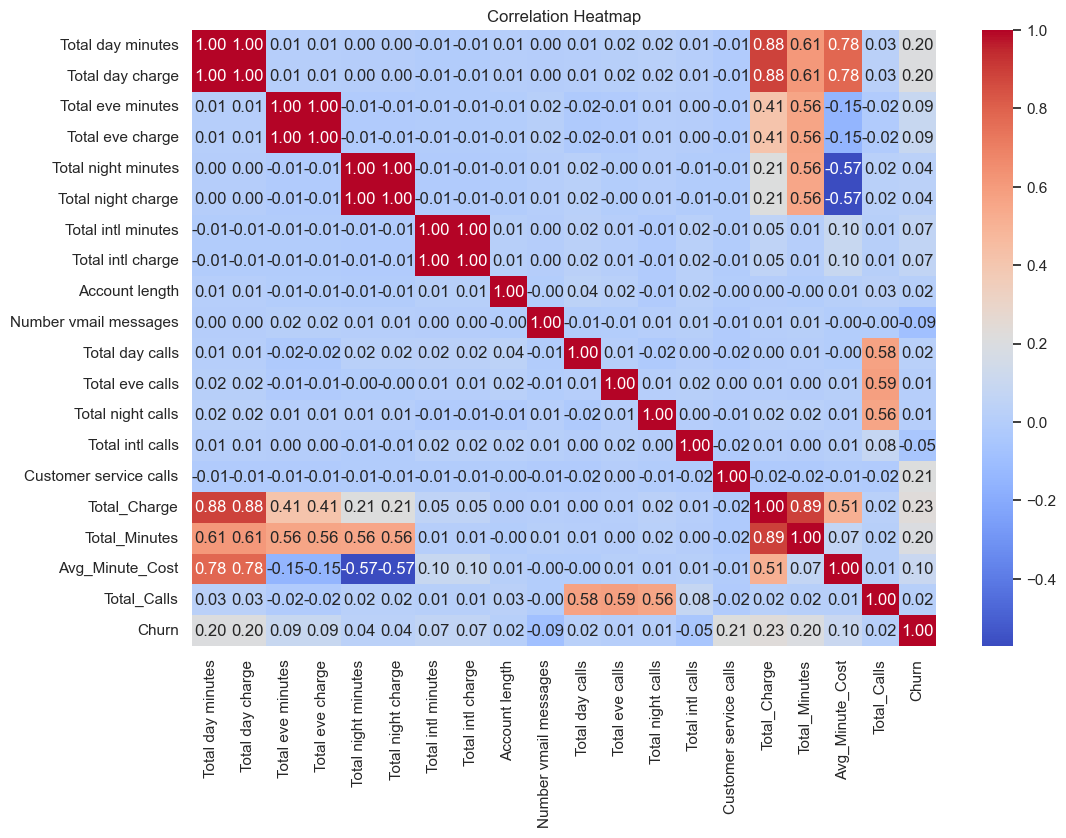

In [36]:
# 7. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation = df[numeric_cols + ['Churn']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig(f'../visualizations/enhanced/correlation_heatmap.png')
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6200\3434641299.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_churn.values, y=state_churn.index, palette='Set2')


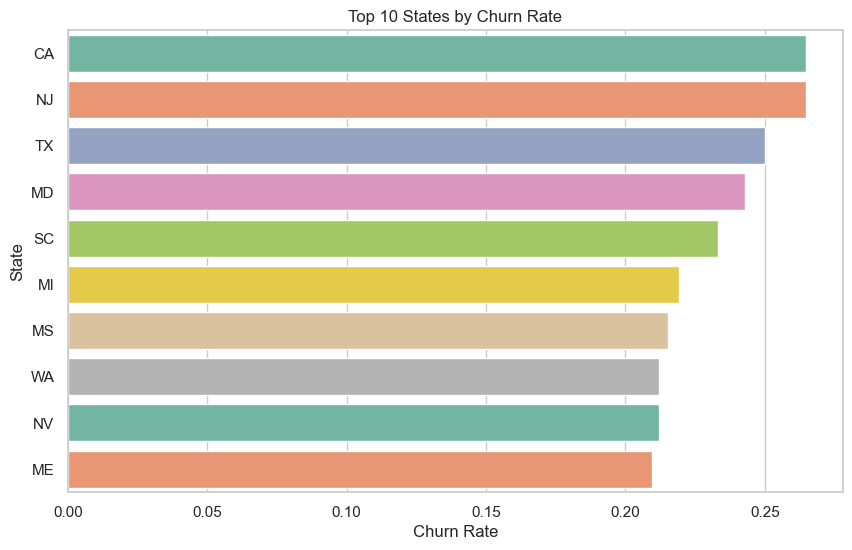

In [37]:
# 8. Churn Rate by State (Top 10 States by Count)
state_churn = df.groupby('State')['Churn'].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=state_churn.values, y=state_churn.index, palette='Set2')
plt.title('Top 10 States by Churn Rate')
plt.xlabel('Churn Rate')
plt.savefig(f'../visualizations/enhanced/top_10_states_by_churn_rate.png')
plt.show()

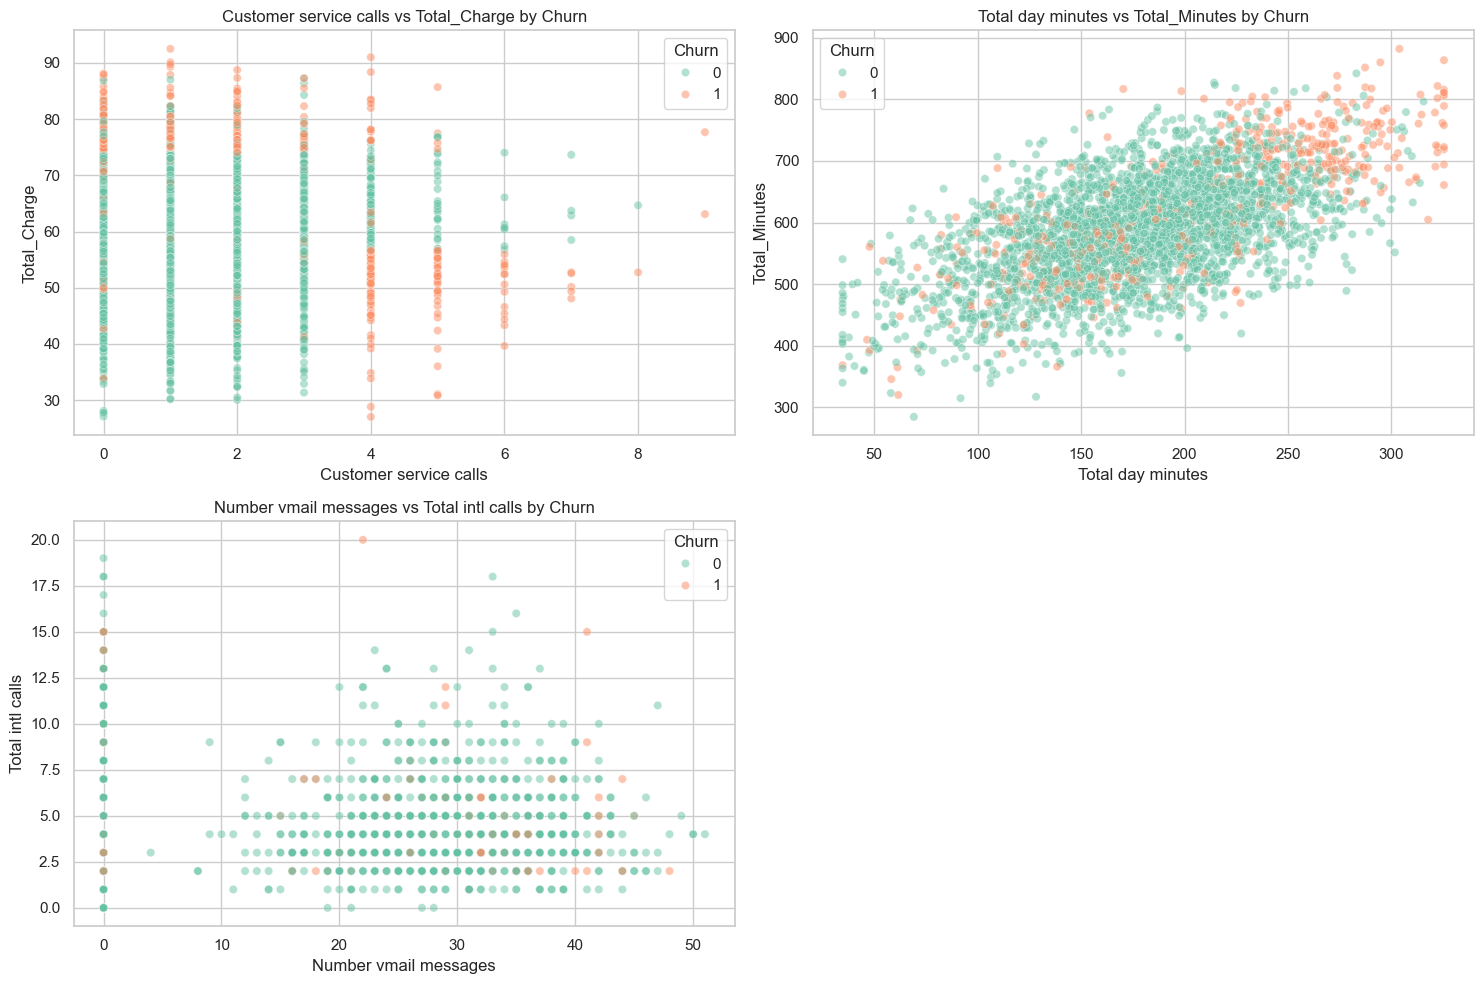

In [38]:
# Define key feature pairs based on correlation with Churn
scatter_pairs = [
    ('Customer service calls', 'Total_Charge'),
    ('Total day minutes', 'Total_Minutes'),
    ('Number vmail messages', 'Total intl calls')
]

# Set up the figure
plt.figure(figsize=(15, 10))
n_cols = 2 
n_rows = int(np.ceil(len(scatter_pairs) / n_cols)) 

# Create scatter plots
for i, (x_col, y_col) in enumerate(scatter_pairs, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='Churn', palette='Set2', alpha=0.5)
    plt.title(f'{x_col} vs {y_col} by Churn')

plt.tight_layout()
plt.savefig(f'../visualizations/enhanced/scatter_plots_key_features.png')
plt.show()